# Discovery techniques

Querying the database can be done with anything which support attaching to a PostGreSQL database. Many interface libraries for a variety of programming languages exist, so this is in the end a user's choice.

That being said, often there are queries which need to be done more often, and it pays off to build convenience functions which wrap a database query. Commonly used query wrapper are found in the [discover subdirectory](../reference/geoslurp.discover.html#module-geoslurp.discover). 

Below are a few examples which demonstrate the use of sqlalchemy to perform queries. They make use of the data which has been registered in [this notebook](../examples/CreateDynDSet.html#Download-and-register-a-dataset-of-(fictious?)-US-Marijuana-street-prices). The queries are encapsulated in functions which return an iteratable object which is the result of the query. This is also the same pattern as most functions in the  *discover* directory obey.

In [2]:
from geoslurp.config import setInfoLevel
from geoslurp.db import geoslurpConnect
setInfoLevel()

gpcon=geoslurpConnect() # this will be a connection based on the readonly user

## Query a single table and visualize the result

In [6]:
from sqlalchemy import select,asc
def queryState(dbcon,state):
    """Query the usweedprices2 table for a given state, while sorting the results according to their timestamp"""
    #retrieve/reflect the table (note the lowercase table name)
    tbl=dbcon.getTable('usweedprices2','public')

    qry=select([tbl]).where(tbl.c.State == state).order_by(asc(tbl.c.date))
    
    return dbcon.dbeng.execute(qry)

### Pick a state and plot the results using matplotlib

Text(0.5, 0, 'date')

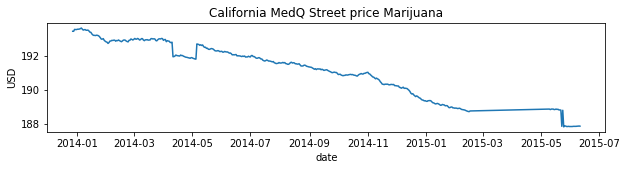

In [14]:
import matplotlib.pyplot as mpl
from datetime import datetime

statename="California"

t=[]
medq=[]
for entry in queryState(gpcon,statename):
    t.append(datetime.strptime(entry.date, "%Y-%m-%d"))
    medq.append(entry.MedQ)


fig,ax=mpl.subplots(figsize=(10,2))
ax.plot(t,medq)
mpl.ylabel("USD")
mpl.title("%s MedQ Street price Marijuana"%statename)
mpl.xlabel("date")

## A more complicated query which joins data between tables
Imagine you want to geographically compare the average street price in 2024 between US states, and geographically visualize this.

This requires a query which computes the average per State and an inner join with a table which contains the polygons of the states.

In [61]:
from sqlalchemy.sql import join
def queryAveragePerState(dbcon):
    
    #find the two relevant tables
    usw=dbcon.getTable('usweedprices2','public')
    stategeo=dbcon.getTable('ne_110m_admin_1_states_provinces','globalgis')
    
    #create a subquery with averages per state
    subqry1=select([usw.c.State,func.avg(usw.c.MedQ).label("avg")]).group_by(usw.c.State).alias("uswt")
    
    #join the subquery with polygon data from the stategeo table
    j=join(subqry1,stategeo,subqry1.c.State == stategeo.c.name)
   
    qry=select([qry1.c.State,qry1.c.avg,stategeo.c.geom]).select_from(j)

    return dbcon.dbeng.execute(qry)

        

In [60]:
for entry in queryAveragePerState(gpcon):
    print(entry.State,entry.avg)

SELECT uswt."State", uswt.avg, globalgis.ne_110m_admin_1_states_provinces.geom 
FROM (SELECT public.usweedprices2."State" AS "State", avg(public.usweedprices2."MedQ") AS avg 
FROM public.usweedprices2 GROUP BY public.usweedprices2."State") AS uswt JOIN globalgis.ne_110m_admin_1_states_provinces ON uswt."State" = globalgis.ne_110m_admin_1_states_provinces.name
Minnesota 275.850066815145
Montana 248.39855233853
North Dakota 349.066681514477
Hawaii 268.738151447661
Idaho 249.822427616927
Washington 189.924988864143
Arizona 209.365345211581
California 191.268908685969
Colorado 196.532516703786
Nevada 226.217416481069
New Mexico 209.242249443207
Oregon 183.889866369711
Utah 237.371893095769
Wyoming 358.534832962139
Arkansas 190.414654788419
Iowa 289.9455233853
Kansas 261.243073496659
Missouri 244.812204899777
Nebraska 248.160645879733
Oklahoma 233.822004454343
South Dakota 351.944810690423
Alabama 204.606169265033
Louisiana 243.117884187082
Texas 233.536837416481
Connecticut 271.32389755011